# Unsupervised learning - clustering 

Cluster particle signatures into 3+ catagories. This should also be based maximum 10 variables from the Electron Variable List. In this case, there is no target variable, as this is unsupervised learning. We evaluate algorithm performance by ability of your catagories to fit into electron/non-electron classification. 

We start by opening the files and loading them into a Numpy array

In [24]:
import h5py
import pandas
from copy import deepcopy
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingClassifier
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import KernelPCA




import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

In [25]:
def load_data(name):
    with h5py.File(f'{name}.h5', 'r') as f:
        return pandas.DataFrame(f[name][:])

train = load_data('train')
test  = load_data('test')

In [26]:
## temporarily use a fraction of the data to speed everything up
train=train.sample(frac = 0.1)

Then we can verify the shape

In [27]:
print (f'Shape of training data set: {train.shape}')
print (f'Shape of test data set: {test.shape}')

Shape of training data set: (16250, 166)
Shape of test data set: (160651, 164)


As expected, the test set contains 2 columns less: `Truth` and `p_truth_E`.
    
Then we copy the variable list from the course website <https://www.nbi.dk/~petersen/Teaching/ML2020/SmallProject/VariableList.html>

In [28]:
all_variables = ['actualInteractionsPerCrossing', 'averageInteractionsPerCrossing', 'correctedActualMu', 'correctedAverageMu', 'correctedScaledActualMu', 'correctedScaledAverageMu', 'NvtxReco', 'p_nTracks', 'p_pt_track', 'p_eta', 'p_phi', 'p_charge', 'p_qOverP', 'p_z0', 'p_d0', 'p_sigmad0', 'p_d0Sig', 'p_EptRatio', 'p_dPOverP', 'p_z0theta', 'p_etaCluster', 'p_phiCluster', 'p_eCluster', 'p_rawEtaCluster', 'p_rawPhiCluster', 'p_rawECluster', 'p_eClusterLr0', 'p_eClusterLr1', 'p_eClusterLr2', 'p_eClusterLr3', 'p_etaClusterLr1', 'p_etaClusterLr2', 'p_phiClusterLr2', 'p_eAccCluster', 'p_f0Cluster', 'p_etaCalo', 'p_phiCalo', 'p_eTileGap3Cluster', 'p_cellIndexCluster', 'p_phiModCalo', 'p_etaModCalo', 'p_dPhiTH3', 'p_R12', 'p_fTG3', 'p_weta2', 'p_Reta', 'p_Rphi', 'p_Eratio', 'p_f1', 'p_f3', 'p_Rhad', 'p_Rhad1', 'p_deltaEta1', 'p_deltaPhiRescaled2', 'p_TRTPID', 'p_TRTTrackOccupancy', 'p_numberOfInnermostPixelHits', 'p_numberOfPixelHits', 'p_numberOfSCTHits', 'p_numberOfTRTHits', 'p_numberOfTRTXenonHits', 'p_chi2', 'p_ndof', 'p_SharedMuonTrack', 'p_E7x7_Lr2', 'p_E7x7_Lr3', 'p_E_Lr0_HiG', 'p_E_Lr0_LowG', 'p_E_Lr0_MedG', 'p_E_Lr1_HiG', 'p_E_Lr1_LowG', 'p_E_Lr1_MedG', 'p_E_Lr2_HiG', 'p_E_Lr2_LowG', 'p_E_Lr2_MedG', 'p_E_Lr3_HiG', 'p_E_Lr3_LowG', 'p_E_Lr3_MedG', 'p_ambiguityType', 'p_asy1', 'p_author', 'p_barys1', 'p_core57cellsEnergyCorrection', 'p_deltaEta0', 'p_deltaEta2', 'p_deltaEta3', 'p_deltaPhi0', 'p_deltaPhi1', 'p_deltaPhi2', 'p_deltaPhi3', 'p_deltaPhiFromLastMeasurement', 'p_deltaPhiRescaled0', 'p_deltaPhiRescaled1', 'p_deltaPhiRescaled3', 'p_e1152', 'p_e132', 'p_e235', 'p_e255', 'p_e2ts1', 'p_ecore', 'p_emins1', 'p_etconeCorrBitset', 'p_ethad', 'p_ethad1', 'p_f1core', 'p_f3core', 'p_maxEcell_energy', 'p_maxEcell_gain', 'p_maxEcell_time', 'p_maxEcell_x', 'p_maxEcell_y', 'p_maxEcell_z', 'p_nCells_Lr0_HiG', 'p_nCells_Lr0_LowG', 'p_nCells_Lr0_MedG', 'p_nCells_Lr1_HiG', 'p_nCells_Lr1_LowG', 'p_nCells_Lr1_MedG', 'p_nCells_Lr2_HiG', 'p_nCells_Lr2_LowG', 'p_nCells_Lr2_MedG', 'p_nCells_Lr3_HiG', 'p_nCells_Lr3_LowG', 'p_nCells_Lr3_MedG', 'p_pos', 'p_pos7', 'p_poscs1', 'p_poscs2', 'p_ptconeCorrBitset', 'p_ptconecoreTrackPtrCorrection', 'p_r33over37allcalo', 'p_topoetconeCorrBitset', 'p_topoetconecoreConeEnergyCorrection', 'p_topoetconecoreConeSCEnergyCorrection', 'p_weta1', 'p_widths1', 'p_widths2', 'p_wtots1', 'p_e233', 'p_e237', 'p_e277', 'p_e2tsts1', 'p_ehad1', 'p_emaxs1', 'p_fracs1', 'p_DeltaE', 'p_E3x5_Lr0', 'p_E3x5_Lr1', 'p_E3x5_Lr2', 'p_E3x5_Lr3', 'p_E5x7_Lr0', 'p_E5x7_Lr1', 'p_E5x7_Lr2', 'p_E5x7_Lr3', 'p_E7x11_Lr0', 'p_E7x11_Lr1', 'p_E7x11_Lr2', 'p_E7x11_Lr3', 'p_E7x7_Lr0', 'p_E7x7_Lr1' ]

Finally, we divide the training data into data (`X`) and targets (`y`)

Only use the entries which we know are true electrons for training.


In [29]:
train = train.loc[train['Truth']==1]
X = train[all_variables]
y = train['Truth']

print (f'Shape of X: {X.shape}')
print (f'Shape of y: {y.shape}')

Shape of X: (12092, 160)
Shape of y: (12092,)


In [30]:
X.head(2)

,actualInteractionsPerCrossing,averageInteractionsPerCrossing,correctedActualMu,correctedAverageMu,correctedScaledActualMu,correctedScaledAverageMu,NvtxReco,p_nTracks,p_pt_track,p_eta,...,p_E5x7_Lr0,p_E5x7_Lr1,p_E5x7_Lr2,p_E5x7_Lr3,p_E7x11_Lr0,p_E7x11_Lr1,p_E7x11_Lr2,p_E7x11_Lr3,p_E7x7_Lr0,p_E7x7_Lr1
150324,43.5,43.5,43.5,43.5,43.5,43.5,21,3,25820.814453,-1.991660,...,0.000000,29178.632812,94045.726562,833.941711,0.000000,29877.998047,98459.773438,806.016785,0.000000,29877.998047
112483,39.5,39.5,39.5,39.5,39.5,39.5,25,3,50991.351562,1.666474,...,11968.785156,39848.300781,68978.617188,103.914528,12431.539062,39834.062500,70204.492188,302.991974,12431.539062,39834.062500


## Preprocessing

### Check null values

In [31]:
train.isnull().sum()

eventNumber                       0
runNumber                         0
actualInteractionsPerCrossing     0
averageInteractionsPerCrossing    0
correctedActualMu                 0
                                 ..
p_E7x11_Lr2                       0
p_E7x11_Lr3                       0
p_E7x7_Lr0                        0
p_E7x7_Lr1                        0
index                             0
Length: 166, dtype: int64

No nulls
### Scale the data

In [32]:
transformed_X = deepcopy(X) 
# This loop transforms every variable _independently_ 
for variable in X.columns:     
    transformed_X[variable] = RobustScaler().fit_transform(np.array(transformed_X[variable]).reshape(-1,1))

### Select k Best features  
Use the electron/not electron truth field to choose the 10 best features

In [33]:
from sklearn.feature_selection import SelectKBest, f_regression, f_classif

In [34]:
X_10 = SelectKBest(score_func=f_classif, k=10).fit_transform(X,y)
X_10.shape

/opt/conda/envs/python3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)


(12092, 10)

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X_10, y, test_size=0.25, 
                                                    shuffle=True, random_state=42)

# K-Means clustering

100%|██████████| 8/8 [00:39<00:00,  4.88s/it]


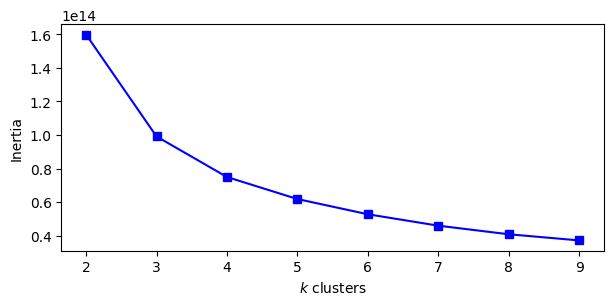

In [46]:
from sklearn.cluster import KMeans

# loop over several k values and record inertias
ks = np.arange(2, 10)
inertias = []
for k in tqdm(ks):
    kmeans = KMeans(n_clusters=k, init='k-means++', 
                    n_init=10, random_state=42)
    kmeans.fit(X_train)
    inertias.append(kmeans.inertia_)

fig, ax = plt.subplots(1, dpi=100, figsize=(7,3), 
                       subplot_kw={'xlabel': '$k$ clusters', 
                                   'ylabel': 'Inertia'})
plt.plot(ks, inertias, 'bs-')
#plt.plot(3, inertias[1], 'rs')
plt.show()

In [89]:
# from sklearn.metrics import silhouette_score

# ks = np.arange(2, 10)
# scores = []
# for k in tqdm(ks):
#     kmeans = KMeans(n_clusters=k, init='k-means++', 
#                     n_init=10, random_state=42)
#     kmeans.fit(X_10)
#     scores.append(silhouette_score(X_10, kmeans.labels_))

# fig, ax = plt.subplots(1, dpi=100, figsize=(7,3), 
#                        subplot_kw={'xlabel': '$k$ clusters', 
#                                    'ylabel': 'Silhouette Score'})
# plt.plot(ks, scores, 'bs-')
# #plt.plot(3, scores[1], 'rs')
# plt.show()

In [51]:
kmeans = KMeans(n_clusters=2, init='k-means++', 
                n_init=10, random_state=42)
kmeans.fit(X_train)
y_pred = kmeans.predict(X_val)

test_score = accuracy_score(y_val, y_pred)
print(f"Test score: {test_score:.3f}")

Test score: 0.548


## UMAP

In [63]:
!pip install umap-learn

In [2]:
import umap.umap_ as umap

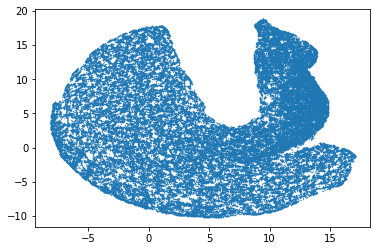

In [69]:
# standard_embedding = umap.UMAP(random_state=42).fit_transform(X_train.data)
# plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], s=0.1, cmap='Spectral');

In [36]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
)

In [39]:
X_train_umap = clusterable_embedding.fit_transform(X_train)
X_val_umap = clusterable_embedding.transform(X_val)

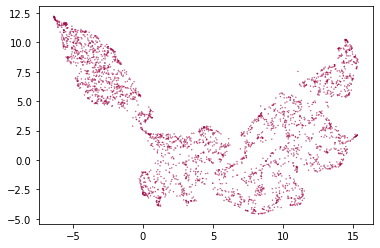

In [41]:
plt.scatter(X_val_umap[:, 0], X_val_umap[:, 1],
            c=y_val, s=0.1, cmap='Spectral');

### Gaussian mixture model

In [43]:
gm_umap = GaussianMixture(n_components=2, random_state=0).fit(X_train_umap)
y_pred_umap = gm_umap.predict(X_val_umap)

test_score_umap = accuracy_score(y_val, y_pred_umap)
print(f"Test score: {test_score_umap:.3f}")

Test score: 0.349
